# DEMO

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import torch 
import torch.nn as nn
import torch.nn.functional as F
import loralib as lora
import clip 

from PIL import Image
import cv2
from scipy import ndimage
from skimage.filters import gaussian, threshold_otsu

import math
from typing import Tuple, List, Dict
from abc import ABC, abstractmethod

from transformers import AutoModelForCausalLM 

/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparams

In [2]:
Image.MAX_IMAGE_PIXELS = 100000000000

## Preprocess

In [3]:
def _get_tissue_mask(
    image: np.ndarray,
    n_thresholding_steps: int = 1,
    sigma: float = 0.0,
    min_size: int = 500,
) -> Tuple[np.ndarray, np.ndarray]:
    """Get binary tissue mask

    Args:
        image (np.ndarray):
            (m, n, 3) nd array of thumbnail RGB image
            or (m, n) nd array of thumbnail grayscale image
        n_thresholding_steps (int, optional): number of gaussian smoothign steps. Defaults to 1.
        sigma (float, optional): sigma of gaussian filter. Defaults to 0.0.
        min_size (int, optional): minimum size (in pixels) of contiguous tissue regions to keep. Defaults to 500.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            np int32 array
                each unique value represents a unique tissue region
            np bool array
                largest contiguous tissue region.
    """
    if len(image.shape) == 3:
        # grayscale thumbnail (inverted)
        thumbnail = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    else:
        thumbnail = image

    if len(np.unique(thumbnail)) == 1:
        return None, None

    for _ in range(n_thresholding_steps):

        # gaussian smoothing of grayscale thumbnail
        if sigma > 0.0:
            thumbnail = gaussian(
                thumbnail,
                sigma=sigma,
                mode="nearest",
                preserve_range=True)

        # get threshold to keep analysis region
        try:
            thresh = threshold_otsu(thumbnail[thumbnail > 0])
        except ValueError:  # all values are zero
            thresh = 0

        # replace pixels outside analysis region with upper quantile pixels
        thumbnail[thumbnail < thresh] = 0

    # convert to binary
    mask = 0 + (thumbnail > 0)

    # find connected components
    labeled, _ = ndimage.label(mask)

    # only keep
    unique, counts = np.unique(labeled[labeled > 0], return_counts=True)
    if len(unique) != 0:
        discard = np.in1d(labeled, unique[counts < min_size])
        discard = discard.reshape(labeled.shape)
        labeled[discard] = 0
        # largest tissue region
        mask = labeled == unique[np.argmax(counts)]
        return labeled, mask
    else:
        return None, None

In [4]:
class GaussianTissueMask:
    """Helper class to extract tissue mask from images"""

    def __init__(
        self,
        n_thresholding_steps: int = 1,
        sigma: int = 20,
        min_size: int = 10,
        kernel_size: int = 20,
        dilation_steps: int = 1,
        background_gray_value: int = 228,
        downsampling_factor: int = 4,
        **kwargs,
    ) -> None:
        """
        Args:
            n_thresholding_steps (int, optional): Number of gaussian smoothing steps. Defaults to 1.
            sigma (int, optional): Sigma of gaussian filter. Defaults to 20.
            min_size (int, optional): Minimum size (in pixels) of contiguous tissue regions to keep. Defaults to 10.
            kernel_size (int, optional): Dilation kernel size. Defaults to 20.
            dilation_steps (int, optional): Number of dilation steps. Defaults to 1.
            background_gray_value (int, optional): Gray value of background pixels (usually high). Defaults to 228.
            downsampling_factor (int, optional): Downsampling factor from the input image
                                                 resolution. Defaults to 4.
        """
        self.n_thresholding_steps = n_thresholding_steps
        self.sigma = sigma
        self.min_size = min_size
        self.kernel_size = kernel_size
        self.dilation_steps = dilation_steps
        self.background_gray_value = background_gray_value
        self.downsampling_factor = downsampling_factor
        super().__init__(**kwargs)
        self.kernel = np.ones((self.kernel_size, self.kernel_size), "uint8")

    @staticmethod
    def _downsample(image: np.ndarray, downsampling_factor: int) -> np.ndarray:
        """Downsample an input image with a given downsampling factor
        Args:
            image (np.array): Input tensor
            downsampling_factor (int): Factor to downsample
        Returns:
            np.array: Output tensor
        """
        height, width = image.shape[0], image.shape[1]
        new_height = math.floor(height / downsampling_factor)
        new_width = math.floor(width / downsampling_factor)
        print(f"Original size: {width}x{height}")
        print(f"Downsampling factor: {downsampling_factor}")
        print(f"New size: {new_width}x{new_height}")

        downsampled_image = cv2.resize(
            image, (new_width, new_height), interpolation=cv2.INTER_NEAREST
        )
        return downsampled_image

    @staticmethod
    def _upsample(
            image: np.ndarray,
            new_height: int,
            new_width: int) -> np.ndarray:
        """Upsample an input image to a speficied new height and width
        Args:
            image (np.array): Input tensor
            new_height (int): Target height
            new_width (int): Target width
        Returns:
            np.array: Output tensor
        """
        upsampled_image = cv2.resize(
            image, (new_width, new_height), interpolation=cv2.INTER_NEAREST
        )
        return upsampled_image

    # type: ignore[override]
    def process(self, image: np.ndarray) -> np.ndarray:
        """Return the superpixels of a given input image
        Args:
            image (np.array): Input image
        Returns:
            np.array: Extracted tissue mask
        """
        # Downsample image
        original_height, original_width = image.shape[0], image.shape[1]
        if self.downsampling_factor != 1:
            image = self._downsample(image, self.downsampling_factor)

        tissue_mask = np.zeros(shape=(image.shape[0], image.shape[1]))
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Detect tissue region
        while True:
            _, mask_ = _get_tissue_mask(
                image,
                n_thresholding_steps=self.n_thresholding_steps,
                sigma=self.sigma,
                min_size=self.min_size,
            )
            if mask_ is None:
                break
            mask_ = cv2.dilate(
                mask_.astype(
                    np.uint8),
                self.kernel,
                iterations=self.dilation_steps)
            image_masked = mask_ * image_gray

            if image_masked[image_masked > 0].mean(
            ) < self.background_gray_value:
                tissue_mask[mask_ != 0] = 1
                image[mask_ != 0] = (255, 255, 255)
            else:
                break
        tissue_mask = tissue_mask.astype(np.uint8)

        tissue_mask = self._upsample(
            tissue_mask, original_height, original_width)
        return tissue_mask

In [5]:
# moondream
def load_md(
    device: str = "cuda"
):
    device = torch.device(device)
    model = AutoModelForCausalLM.from_pretrained(
        "vikhyatk/moondream2",
        revision="2025-01-09",
        trust_remote_code=True,
    ).to(device)
    return model

def describe_img(
    image_path: str,
    device: str = "cuda"
):
    img = Image.open(image_path)
    model = load_md(device)
    enc_image = model.encode_image(img)
    print(model.query(enc_image, "Describe this image.\n"))

def read_image(
    image_fpath: str
) -> np.ndarray:
    return np.array(Image.open(image_fpath))

def get_tissue_mask(
    image: np.ndarray,
    kernel_size: int = 20,
    sigma: int = 20,
    downsample: int = 8,
    background_gray_threshold: int = 220,
    **kwargs
) -> np.ndarray:
    tissue_detector = GaussianTissueMask(
        kernel_size=kernel_size,
        sigma=sigma,
        downsampling_factor=downsample,
        background_gray_value=background_gray_threshold
    )
    return tissue_detector.process(image)

def get_image_patches(
    image: np.ndarray, 
    tissue_mask: np.ndarray,
    patch_size: int = 512,
    patch_tissue_threshold: float = 0.7,
    is_visualize: bool = True
) -> List[np.ndarray]:
    patch_threshold = int(patch_size * patch_size * patch_tissue_threshold)
    
    # image and tissue mask pre-processing
    h, w, c = image.shape
    pad_b = patch_size - h % patch_size
    pad_r = patch_size - w % patch_size
    image_ = np.pad(image, ((0, pad_b), (0, pad_r), (0, 0)), mode='constant', constant_values=255)
    tissue_mask_ = np.pad(tissue_mask, ((0, pad_b), (0, pad_r)), mode='constant', constant_values=0)
    
    if is_visualize:
        fig, ax = plt.subplots()
        ax.imshow(Image.fromarray(image_))
    
    # extract patches
    patches = []
    for y in range(0, image_.shape[0], patch_size):
        for x in range(0, image_.shape[1], patch_size):
            tissue_patch_ = tissue_mask_[y:y + patch_size, x:x + patch_size]
            if np.sum(tissue_patch_) > patch_threshold:
                patches.append(
                    image_[y:y + patch_size, x:x + patch_size, :]
                )
    
                if is_visualize:
                    rect = matplotlib.patches.Rectangle((x, y), patch_size, patch_size,
                                             linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
    
    if is_visualize:
        plt.show()
        
    return patches

def resize_patch(image):
    img = cv2.resize(image, (32, 32))
    return img

def normalize_patch(image):
    norm_img = cv2.normalize(
        image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )
    return norm_img

def convert_patch_to_tensor(patch: np.ndarray) -> torch.Tensor:
    patch = torch.tensor(patch).permute(2, 0, 1).unsqueeze(0).float()
    return patch

# Model

In [6]:
class AbstractAttention(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass

class AbstractVAE(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass

    def get_pool_indices(self) -> Dict[int, torch.Tensor]:
        """
        Returns the pooling indices from the last forward pass.
        
        Returns:
            Dictionary mapping layer indices to pooling indices tensors
        """
        return self.pool_indices
    
    def get_pool_sizes(self) -> Dict[int, torch.Size]:
        """
        Returns the pre-pooling tensor sizes from the last forward pass.
        Useful for unpooling operations.
        
        Returns:
            Dictionary mapping layer indices to pre-pooling tensor sizes
        """
        return self.pool_sizes


## Network

In [7]:
class CrossAttentionStyleFusion(AbstractAttention):
    def __init__(
        self, 
        latent_channels=4, 
        cond_dim=256,
        *args,
        **kwargs
    ):
        super().__init__()
        self.norm = nn.GroupNorm(2, latent_channels)
        self.proj_q = lora.Conv2d(latent_channels, latent_channels, 1)
        self.proj_k = lora.Linear(cond_dim, latent_channels)
        self.proj_v = lora.Linear(cond_dim, latent_channels)
        self.proj_out = lora.Conv2d(latent_channels, latent_channels, 1)
        
    def forward(self, x, cond):
        # x: [B, 4, H, W], cond: [B, 256]
        B, C, H, W = x.shape
        
        # Normalize and get query
        h = self.norm(x)
        q = self.proj_q(h)                      # [B, 4, H, W]
        q = q.reshape(B, C, -1)                 # [B, 4, H*W]
        
        # Get key and value from condition
        k = self.proj_k(cond).unsqueeze(-1)     # [B, 4, 1]
        v = self.proj_v(cond).unsqueeze(-1)     # [B, 4, 1]
        
        # Attention
        weight = torch.bmm(q.permute(0, 2, 1), k)  # [B, H*W, 1]
        weight = F.softmax(weight, dim=1)
        
        # Apply attention and reshape back to spatial dimensions
        h = torch.bmm(v, weight.permute(0, 2, 1))  # [B, 4, H*W]
        h = h.reshape(B, C, H, W)                  # [B, 4, H, W]

        return x + self.proj_out(h)

## ViT

In [46]:
class VisionLanguageProjector(nn.Module):
    def __init__(
        self,
        input_dim: int = 512,
        output_dim: int = 256,
        device: str = "cuda",
        is_trainable: bool = True,
        lora_rank: int = 8,
        *args,
        **kwargs
    ):
        super(VisionLanguageProjector, self).__init__()
        self.device = device

        self.mlp = nn.Sequential(
            lora.Linear(input_dim, input_dim * 2, r=lora_rank),
            nn.ReLU(),
            lora.Linear(input_dim * 2, output_dim, r=lora_rank),
        )
        if is_trainable:
            lora.mark_only_lora_as_trainable(self.mlp)

    def forward(self, x):
        x = self.mlp(x)
        return x



# Utils function
def load_clip(device: str = "cuda"):
    """
    Load CLIP model and pre-processing pipeline
    
    ------------------------------------------------------------------------------
    Args:
        device (str): Device to run the model on
    Output:
        model (torch.nn.Module): CLIP model
        preprocess (torchvision.transforms.Compose): Pre-processing pipeline
    """
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess

def extract_style_embedding(
        image_array: torch.Tensor,
        show: bool = False,
        device: str = "cuda",
        savefig: bool = False
):
    """
    Extract style embedding from an image using CLIP model combined with proposed Vision-Language Projector

    ------------------------------------------------------------------------------
    Args:
        image_array (torch.Tensor): torch Tensor of shape (C, H, W) representing the image
        show (bool): Whether to display the style embedding as an image
        device (str): Device to run the model on
    Output: 
        style_embedding (torch.Tensor): Style embedding of the image
    """
    model, preprocess = load_clip(device)

    style_image = Image.fromarray(image_array.permute(1, 2, 0).numpy().astype('uint8')).convert("RGB")
    style_tensor = preprocess(style_image).unsqueeze(0).to(device)
    # Extract features using CLIP image encoder
    with torch.no_grad():
        image_features = model.encode_image(style_tensor)

    # Normalize the image features (similar to text embeddings)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    print("Image Features Shape:", image_features.shape)


    # Pass through Vision-Language Projector
    vl_projector = VisionLanguageProjector(input_dim=512, output_dim=256).to(device)
    style_embedding = vl_projector(image_features)
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in vl_projector.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")

    print("Transformed Style Embedding Shape:", style_embedding.shape)

    if show:
        _, ax = plt.subplots(2, 1, figsize=(12,2))
        ax[0].imshow(image_features.cpu().detach().numpy(), cmap='viridis')
        ax[0].axis('off')
        ax[0].set_title('Before Projection')
        ax[1].imshow(style_embedding.cpu().detach().numpy(), cmap='viridis')
        ax[1].axis('off')
        ax[1].set_title('After Projection')

        if savefig:
            plt.savefig('assets/style_embedding.png')

        plt.show()
    return style_embedding

## VAE

In [10]:
class VAEncoder(AbstractVAE):
    """
    Variational Autoencoder (VAE) Encoder, adjusted for LoRA, to be plugged into Unet model or Resnet model later
    With MaxPool return_indices support
    """
    def __init__(
        self, 
        in_channels: int = 3,
        latent_channels: int = 4,
        in_channels_params: List[int] = [3, 96, 128, 192],
        out_channels_params: List[int] = [96, 128, 192, 256],
        kernel_params: List[int] = [3, 3, 3, 3],
        stride_params: List[int] = [1, 1, 1, 1],
        padding_params: List[int] = [1, 1, 1, 1],  
        pooling_layers: List[int] = [0,2],  
        activation_function: str = "relu",
        device: str = "cuda",
        *args,
        **kwargs
    ):
        # Initialize hyperparameters
        super(VAEncoder, self).__init__()
        self.in_channels = in_channels
        self.latent_channels = latent_channels
        self.out_channels_params = out_channels_params
        self.kernel_params = kernel_params
        self.pooling_layers = pooling_layers
        self.activation_function = activation_function
        self.device = device
        self.pool_indices = {}  # Store pool indices for each pooling layer
        self.pool_sizes = {}    # Store sizes for unpooling operations

        # Check compatibility of hyperparameters
        if len(in_channels_params) != latent_channels:
            raise ValueError("Number of input channels must be equal to number of latent channels")
        if len(out_channels_params) != latent_channels:
            raise ValueError("Number of output channels must be equal to number of latent channels")
        if len(kernel_params) != latent_channels:
            raise ValueError("Number of kernel sizes must be equal to number of latent channels")

        # Initialize encoder layers - maintain original structure
        for i in range(self.latent_channels):
            # Separate conv + activation from pooling to preserve structure
            # Conv + Activation
            conv_modules = []
            conv_modules.append(lora.Conv2d(
                in_channels=in_channels_params[i], 
                out_channels=out_channels_params[i], 
                kernel_size=kernel_params[i], 
                stride=stride_params[i], 
                padding=padding_params[i])
            )
            
            # Activation function
            if self.activation_function == "relu":
                conv_modules.append(nn.ReLU())
            elif self.activation_function == "silu":
                conv_modules.append(nn.SiLU())
            elif self.activation_function == "gelu":
                conv_modules.append(nn.GELU())
            elif self.activation_function == "celu":
                conv_modules.append(nn.CELU())
            elif self.activation_function == "tanh":
                conv_modules.append(nn.Tanh())
            else:
                raise ValueError("Activation function not supported")
                
            setattr(self, f"conv_{i}", nn.Sequential(*conv_modules))
            
            # Pooling layers (if applicable)
            if i in pooling_layers:
                setattr(self, f"pool_{i}", nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
            
            # Batch normalization (separate to maintain exact structure)
            setattr(self, f"bn_{i}", nn.BatchNorm2d(out_channels_params[i]))

        # Convolution to reduce to latent channels (unchanged)
        self.conv_mu = lora.Conv2d(
            in_channels=out_channels_params[-1], 
            out_channels=latent_channels, 
            kernel_size=1, 
            stride=1, 
            padding=0
        )
        self.conv_logvar = lora.Conv2d(
            in_channels=out_channels_params[-1], 
            out_channels=latent_channels, 
            kernel_size=1, 
            stride=1, 
            padding=0
        )

    def get_mu_logvar(self, x):
        # Clear the pool indices dict each forward pass
        self.pool_indices = {}
        self.pool_sizes = {}
        
        # Process through each encoder block, replicating original flow
        for i in range(self.latent_channels):
            # Apply convolution + activation
            x = getattr(self, f"conv_{i}")(x)
            
            # Apply pooling if this is a pooling layer
            if i in self.pooling_layers:
                # Store the pre-pooling size
                self.pool_sizes[i] = x.size()
                # Apply pooling with indices
                x, indices = getattr(self, f"pool_{i}")(x)
                # Store the indices
                self.pool_indices[i] = indices
            
            # Apply batch normalization
            x = getattr(self, f"bn_{i}")(x)
            
        # Calculate mu and logvar (unchanged)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        
        print(f"Mean shape: {mu.shape}, Log Variance shape: {logvar.shape}")
        
        return mu, logvar
    
    def forward(self, x):
        mu, logvar = self.get_mu_logvar(x)
        # Apply reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

In [11]:
class ConditionedVAEncoder(AbstractVAE):
    def __init__(
        self, 
        in_channels: int = 3,
        latent_channels: int = 4,
        in_channels_params: List[int] = [3, 96, 128, 192],
        out_channels_params: List[int] = [96, 128, 192, 256],
        kernel_params: List[int] = [3, 3, 3, 3],
        stride_params: List[int] = [1, 1, 1, 1],  
        padding_params: List[int] = [1, 1, 1, 1],  
        pooling_layers: List[int] = [0,2],  
        activation_function: str = "relu",
        device: str = "cuda",
        cond_dim: int = 256,
        *args,
        **kwargs
    ):
        super(ConditionedVAEncoder, self).__init__()
        self.encoder = VAEncoder(
            in_channels=in_channels,
            latent_channels=latent_channels,
            in_channels_params=in_channels_params,
            out_channels_params=out_channels_params,
            kernel_params=kernel_params,
            stride_params=stride_params,
            padding_params=padding_params,
            pooling_layers=pooling_layers,
            activation_function=activation_function,
            device=device
        )
        self.conditioning = CrossAttentionStyleFusion(latent_channels=latent_channels, cond_dim=cond_dim)
        
    def forward(self, x, condition_embedding):
        # Apply reparameterization
        mu, logvar = self.encoder.get_mu_logvar(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        print(f"Z shape: {z.shape}, Condition shape: {condition_embedding.shape}")
        # Apply conditioning
        conditioned_z = self.conditioning(z, condition_embedding)
        return conditioned_z

# Test

## Load image

In [10]:
IMAGE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/HE/A3_TMA_15_02_IVB_HE.png"
STYLE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/NKX3/A6_TMA_15_02_IIB_NKX.png"

# tissue mask params
tissue_mask_params = {
    'kernel_size': 20,
    'sigma': 20,
    'downsample': 8,
    'background_gray_threshold': 220
}

# patch extraction params
patch_extraction_params = {
    'patch_size': 128,
    'patch_tissue_threshold': 0.7,
    'is_visualize': True
}

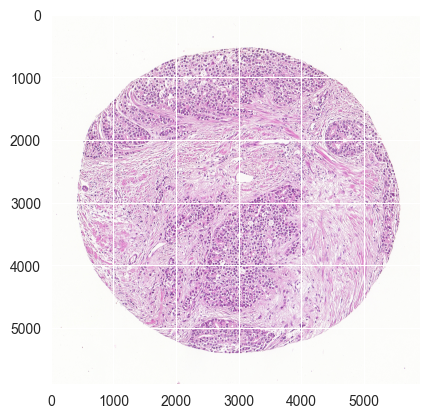

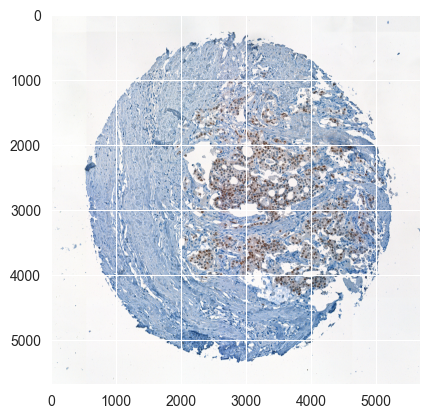

In [11]:
image_src = read_image(IMAGE_PATH)
plt.imshow(image_src)
plt.show()

image_dst = read_image(STYLE_PATH)
plt.imshow(image_dst)
plt.show()

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737


/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_32926/1926581395.py:62: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  discard = np.in1d(labeled, unique[counts < min_size])


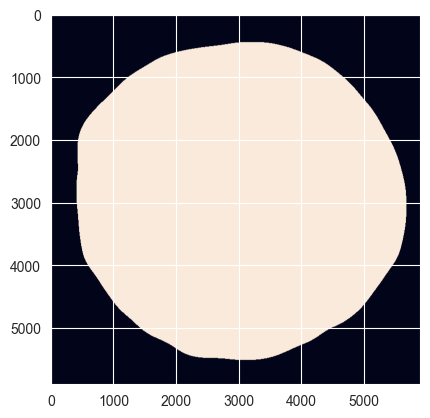

Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


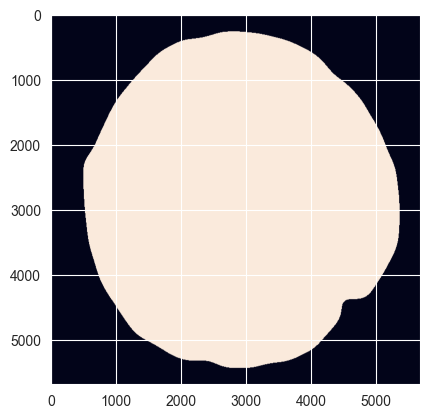

In [12]:
tissue_mask_src = get_tissue_mask(image=image_src, **tissue_mask_params)
plt.imshow(tissue_mask_src)
plt.show()

tissue_mask_dst = get_tissue_mask(image=image_dst, **tissue_mask_params)
plt.imshow(tissue_mask_dst)
plt.show()

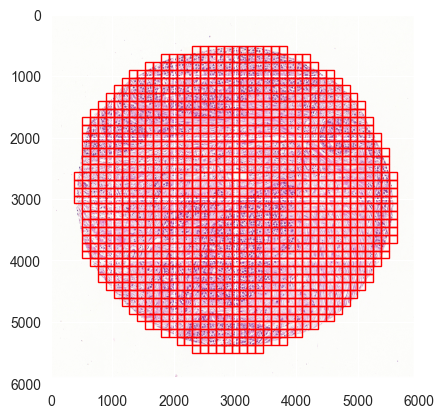

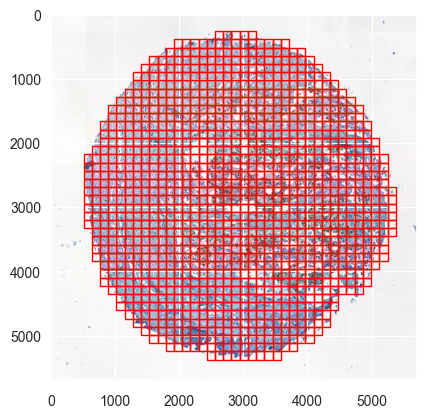

In [13]:
# extract src patches
patches_src = get_image_patches(
    image=image_src,
    tissue_mask=tissue_mask_src,
    **patch_extraction_params
)

# extract dst patches
patches_dst = get_image_patches(
    image=image_dst,
    tissue_mask=tissue_mask_dst,
    **patch_extraction_params
)

## Extract small patches for work

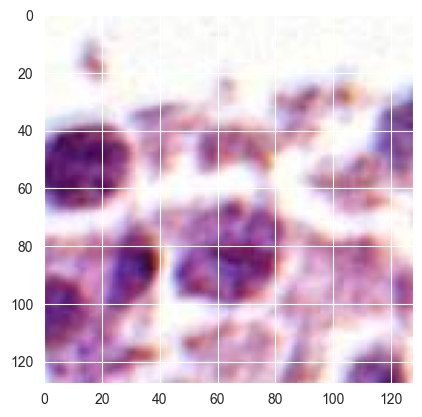

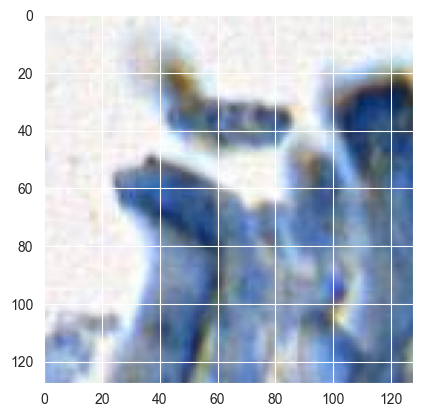

In [14]:
patch_src = normalize_patch(patches_src[5])
plt.imshow(patch_src)
plt.show()
patch_dst = normalize_patch(patches_dst[1])
plt.imshow(patch_dst)
plt.show()

## Extract style embedding

Image Features Shape: torch.Size([1, 512])
Number of trainable parameters: 22528
Transformed Style Embedding Shape: torch.Size([1, 256])


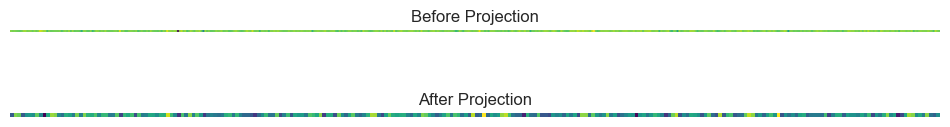

In [47]:
style_embedding = extract_style_embedding(tmp[0], show=True, device="cpu", savefig=False)

## Test VAE Encoder

### Basic version

In [18]:
# Convert patch to tensor
tensor_patch_src = convert_patch_to_tensor(patch_src)

Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])
Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])


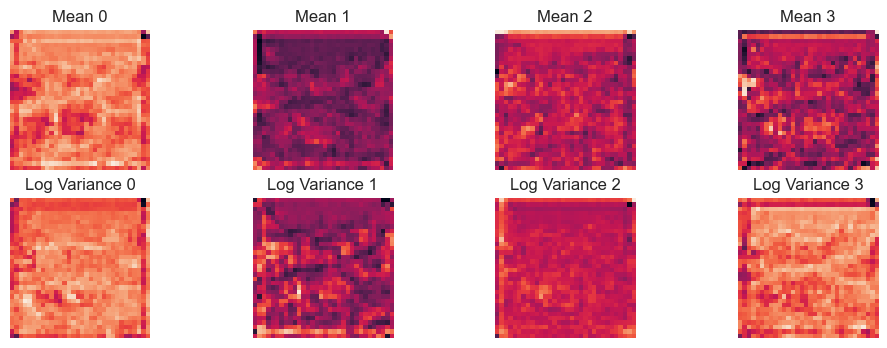

In [19]:
encoder = VAEncoder()
mu, logvar = encoder.get_mu_logvar(tensor_patch_src)

# Show results
print(f"Mean shape: {mu.shape}, Log Variance shape: {logvar.shape}")
fig, ax = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    if i == 0:
        for j in range(len(mu[0])):
            ax[i, j].imshow(mu[0][j].detach().numpy())
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Mean {j}')
    else:
        for j in range(len(logvar[0])):
            ax[i, j].imshow(logvar[0][j].detach().numpy())
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Log Variance {j}')

# plt.savefig("assets/vae_output.png")

### with Attention version

Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])
Z shape: torch.Size([1, 4, 32, 32]), Condition shape: torch.Size([1, 256])
Conditioned Z shape: torch.Size([1, 4, 32, 32])


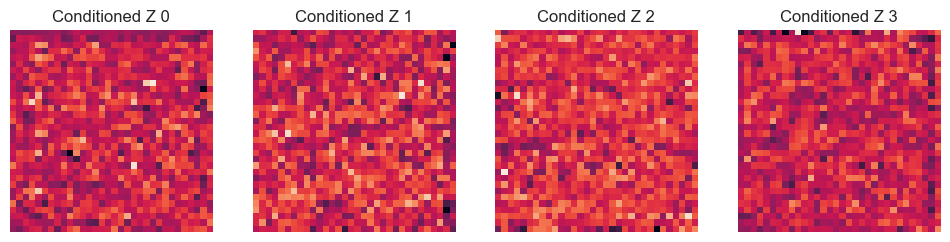

In [20]:
cross_attn_vae = ConditionedVAEncoder(activation_function="celu")
conditioned_z = cross_attn_vae(tensor_patch_src, style_embedding)

# Show results
print(f"Conditioned Z shape: {conditioned_z.shape}")
_, ax = plt.subplots(1, 4, figsize=(12, 4))
for j in range(len(conditioned_z[0])):
    ax[j].imshow(conditioned_z[0][j].detach().numpy())
    ax[j].axis('off')
    ax[j].set_title(f'Conditioned Z {j}')

# plt.savefig("assets/cond_vae_output.png")

# Unet

## ResBlock with Timestep Embedding

### Timestep Block

In [21]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [22]:
timestep_embedding(torch.tensor([0, 200, 400, 1000]), 4)

tensor([[ 1.0000,  1.0000,  0.0000,  0.0000],
        [ 0.4872, -0.4161, -0.8733,  0.9093],
        [-0.5253, -0.6536, -0.8509, -0.7568],
        [ 0.5624, -0.8391,  0.8269, -0.5440]])

In [23]:
class TimestepBlock(nn.Module, ABC):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock) or type(layer).__name__ in ["ResBlock", "CrossAttentionStyleFusion"]:
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

### Upsample Block

In [24]:
class Upsample(nn.Module):
    def __init__(
        self,
        in_channels: int,
        use_conv: bool = True,
        out_channels: int = None,
        *args,
        **kwargs
    ):
        super().__init__()
        self.use_conv = use_conv
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        if use_conv:
            self.conv = lora.Conv2d(in_channels, self.out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

Upsampled conditioned Z shape: torch.Size([1, 4, 64, 64])


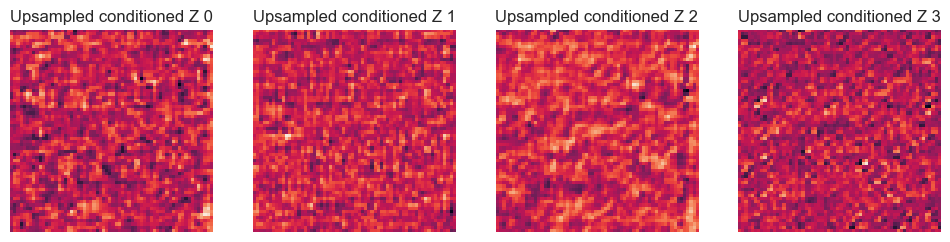

In [25]:
# Test upsample
up = Upsample(4)
tmp = up(conditioned_z)

# Show results
print(f"Upsampled conditioned Z shape: {tmp.shape}")
_, ax = plt.subplots(1, 4, figsize=(12, 4))
for j in range(len(tmp[0])):
    ax[j].imshow(tmp[0][j].detach().numpy())
    ax[j].axis('off')
    ax[j].set_title(f'Upsampled conditioned Z {j}')

# plt.savefig("assets/upsampled_cond_vae_output.png")

### Downsample Block

In [26]:
class Downsample(nn.Module):
    def __init__(
        self,
        in_channels: int,
        use_conv: bool = True,
        out_channels: int = None,
        *args,
        **kwargs
    ):
        super().__init__()
        self.use_conv = use_conv
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        stride = 2
        if use_conv:
            self.op = lora.Conv2d(
                in_channels, 
                self.out_channels, 
                kernel_size=3, 
                stride=stride,
                padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=stride, stride=stride)

    def forward(self, x):
        return self.op(x)

Upsampled conditioned Z shape: torch.Size([1, 4, 16, 16])


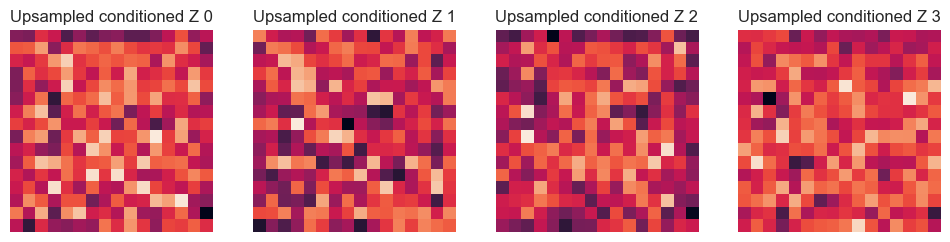

In [27]:
down = Downsample(4)
tmp = down(conditioned_z)

# Show results
print(f"Upsampled conditioned Z shape: {tmp.shape}")
_, ax = plt.subplots(1, 4, figsize=(12, 4))
for j in range(len(tmp[0])):
    ax[j].imshow(tmp[0][j].detach().numpy())
    ax[j].axis('off')
    ax[j].set_title(f'Upsampled conditioned Z {j}')

# plt.savefig("assets/downsampled.png")

## ResBlock

In [28]:
class ResBlock(nn.Module):
    def __init__(
        self,
        emb_channels: int,
        dropout: float,                 # Bottleneck dropout
        in_channels: int = 4,
        use_conv=False,
        out_channels: int = None,
        up=False,
        down=False,
        use_scale_shift_norm=False,
        device=None,
        dtype=torch.float32,
        *args,
        **kwargs
    ):
        # Define parameters
        super().__init__()
        
        # Ensure valid channel values
        self.in_channels = max(in_channels, 1)
        self.out_channels = max(out_channels or in_channels, 1)
        
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.use_conv = use_conv
        self.updown = up or down
        self.use_scale_shift_norm = use_scale_shift_norm
        
        # Explicitly set device and dtype
        self.device = device or torch.device('cpu')
        self.dtype = dtype

        # Define layers
        # Layer 1
        self.in_layers = nn.Sequential(
            nn.BatchNorm2d(
                self.in_channels, 
                device=self.device, 
                dtype=self.dtype
            ),
            nn.SiLU(),
            lora.Conv2d(
                self.in_channels, 
                self.out_channels, 
                kernel_size=3, 
                padding=1,
                device=self.device,
                dtype=self.dtype
            )  
        )

        # Middle layers
        if up:
            self.h_upd = Upsample(
                in_channels, 
                use_conv, 
                out_channels, 
                device=self.device, 
                dtype=self.dtype
            )
            self.x_upd = Upsample(
                in_channels, 
                use_conv, 
                out_channels, 
                device=self.device, 
                dtype=self.dtype
            )
        elif down:
            self.h_upd = Downsample(
                in_channels, 
                use_conv, 
                out_channels, 
                device=self.device, 
                dtype=self.dtype
            )
            self.x_upd = Downsample(
                in_channels, 
                use_conv, 
                out_channels, 
                device=self.device, 
                dtype=self.dtype
            )
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            lora.Linear(
                emb_channels, 
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
                device=self.device,
                dtype=self.dtype
            )
        )

        # Last layers
        self.out_layers = nn.Sequential(
            nn.BatchNorm2d(
                self.out_channels, 
                device=self.device, 
                dtype=self.dtype
            ), 
            nn.SiLU(),
            nn.Dropout(p=dropout),
            lora.Conv2d(
                self.out_channels, 
                self.out_channels, 
                kernel_size=3, 
                padding=1,
                device=self.device,
                dtype=self.dtype
            )
        )

        # Skip connection
        if self.out_channels == self.in_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = lora.Conv2d(
                self.in_channels, 
                self.out_channels, 
                kernel_size=1,
                device=self.device,
                dtype=self.dtype
            )

    def forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        emb_out = self.emb_layers(emb).type(h.dtype)

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale[:, :, None, None]) + shift[:, :, None, None]
            h = out_rest(h)
        else:
            h = h + emb_out[:, :, None, None]
            h = self.out_layers(h)

        res = self.skip_connection(x) + h

        return res

In [29]:
# Create a test tensor (example input)
batch_size = 1
in_channels = 4
out_channels = 8
dim = 16  # Embedding dimension

residual_block = ResBlock(
    emb_channels=dim, 
    dropout=0.5, 
    in_channels=in_channels, 
    out_channels=out_channels, 
    use_conv=True, 
    up=True  # Try with up-sampling
)

Output shape: torch.Size([1, 4, 32, 32])
Output (up) shape: torch.Size([1, 4, 64, 64])
Output (down) shape: torch.Size([1, 4, 16, 16])
Output (up) shape: torch.Size([1, 8, 64, 64])


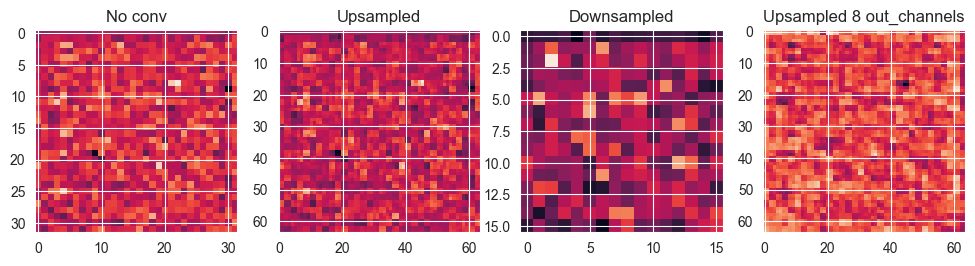

In [30]:
# Define test parameters
batch_size = 1
in_channels = 4
emb_channels = 256
height, width = 32, 32
dropout = 0.1

_, ax = plt.subplots(1, 4, figsize=(12, 4))

# Create test inputs
x = conditioned_z  # Input feature map
emb = style_embedding  # Embedding vector

# Initialize the block (without up/downsampling)
res_block = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    use_conv=False,
    out_channels=4,  # Same as in_channels for skip connection identity
    up=False,
    down=False,
    use_scale_shift_norm=True
)

# Forward pass
output = res_block(x, emb)

# Check output shape
print(f"Output shape: {output.shape}")  # Expected: torch.Size([1, 4, 32, 32])
ax[0].imshow(output[0][0].detach().numpy())

# Additional test with upsampling
res_block_up = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    use_conv=False,
    out_channels=4,
    up=True,
    use_scale_shift_norm=True
)
ax[0].set_title("No conv")

output_up = res_block_up(x, emb)
print(f"Output (up) shape: {output_up.shape}")  # Expected: torch.Size([1, 4, 64, 64])
ax[1].imshow(output_up[0][0].detach().numpy())
ax[1].set_title("Upsampled")

# Additional test with downsampling
res_block_down = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    use_conv=False,
    out_channels=4,
    down=True
)

output_down = res_block_down(x, emb)
print(f"Output (down) shape: {output_down.shape}")  # Expected: torch.Size([1, 4, 16, 16])
ax[2].imshow(output_down[0][0].detach().numpy())
ax[2].set_title("Downsampled")

# Additional test with downsampling
res_block_down = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    use_conv=False,
    out_channels=8,  # Now correctly set to 8
    up=True,  # Only upsampling
    use_scale_shift_norm=True
)
ax[3].set_title("Upsampled 8 out_channels")

output_down = res_block_down(x, emb)
print(f"Output (up) shape: {output_down.shape}")  # Expected: torch.Size([1, 4, 16, 16])
ax[3].imshow(output_down[0][0].detach().numpy())

# plt.savefig("assets/resblock_output_tmp.png")
# plt.show()

## Unet Model

>**Note**: Initialization works but not testing

In [31]:
class UNetModel(nn.Module):
    def __init__(
        self, 
        out_channels,
        model_channels,
        num_res_blocks,
        dropout=0.5,
        in_channels: int = 4,
        image_size: int = 128,
        use_scale_shift_norm=False,
        resblock_updown=False,
        num_classes=None,
        channel_mult=(1, 2, 4, 8),  # Ensure minimum downsampled size is 16x16
        conv_resample=True,
    ):
        super().__init__()
        self.out_channels = out_channels
        self.model_channels = model_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.in_channels = in_channels
        self.image_size = image_size
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown
        self.num_classes = num_classes

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            lora.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            lora.Linear(time_embed_dim, time_embed_dim),
        )

        ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList()
        self.input_blocks.append(nn.ModuleList([lora.Conv2d(in_channels, ch, kernel_size=3, padding=1)]))
        input_block_chans = [ch]
        
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        emb_channels=time_embed_dim,
                        in_channels=ch,
                        dropout=dropout,
                        out_channels=int(mult * model_channels),
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                self.input_blocks.append(nn.ModuleList(layers))
                input_block_chans.append(ch)
            
            if level != len(channel_mult) - 1:
                downsample_block = nn.ModuleList([
                    Downsample(ch, conv_resample, out_channels=ch)
                ])
                self.input_blocks.append(downsample_block)
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                emb_channels=time_embed_dim,
                in_channels=ch,
                dropout=dropout,
                out_channels=ch,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            # ResBlock(
            #     emb_channels=time_embed_dim,
            #     in_channels=ch,
            #     dropout=dropout,
            #     out_channels=ch,
            #     use_scale_shift_norm=use_scale_shift_norm,
            # ),
        )
        
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        emb_channels=time_embed_dim,
                        in_channels=ch + ich,
                        dropout=dropout,
                        out_channels=int(model_channels * mult),
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)

                # Ensure we upsample back to 128×128
                if level != 0 and (ch < self.model_channels * max(channel_mult)):   # Remove condition i == num_res_blocks 
                    layers.append(Upsample(ch, conv_resample, out_channels=ch))

                self.output_blocks.append(TimestepEmbedSequential(*layers))

        # Ensure final resolution is 128×128
        self.final_upsample = Upsample(ch, conv_resample, out_channels=ch)

        
        self.out = nn.Sequential(
            nn.BatchNorm2d(ch),
            nn.SiLU(),
            lora.Conv2d(ch, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps, y=None):
        assert (y is not None) == (self.num_classes is not None)
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        h = x
        for module in self.input_blocks:
            for layer in module:
                h = layer(h) if not isinstance(layer, ResBlock) else layer(h, emb)
                print(f"After {layer.__class__.__name__}: {h.shape}")
            hs.append(h)
        
        h = self.middle_block(h, emb)
        
        for module in self.output_blocks:
            skip = hs.pop()

            # Ensure batch size matches
            if skip.shape[0] != h.shape[0]:
                skip = skip.expand(h.shape[0], -1, -1, -1)  # Expand batch dimension if needed

            # Ensure spatial size matches
            if skip.shape[-2:] != h.shape[-2:]:
                skip = F.interpolate(skip, size=h.shape[-2:], mode="nearest")

            print(f"Upsampling: h={h.shape}, skip={skip.shape}")  # Debugging output
            h = torch.cat([h, skip], dim=1)
            
            for layer in module:
                h = layer(h) if not isinstance(layer, ResBlock) else layer(h, emb)

        
        return self.out(h)

In [32]:
model_params = {
    'out_channels': 4,
    'model_channels': 32,
    'num_res_blocks': 2,
    'dropout': 0.1,
    'in_channels': 4,
    'image_size': 32,
    'use_scale_shift_norm': True,
    'resblock_updown': False,  # Disable excessive downsampling
    'num_classes': None,
    'channel_mult': (1, 2, 4),  # Reduce max depth
    # 'device': torch.device('cpu'),
    # 'dtype': torch.float32
}

# Create the model
model = UNetModel(**model_params)

print("Model initialized successfully!")

# Test the model
conditioned_z = encoder(tensor_patch_src)  # Ensure correct input
print("Conditioned Z shape:", conditioned_z.shape)
timesteps = torch.tensor([0, 200, 400, 1000])

# Debug: Print shapes at each layer
output = model(conditioned_z, timesteps)

print("Output shape:", output.shape)

Model initialized successfully!
Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])
Conditioned Z shape: torch.Size([1, 4, 32, 32])
After Conv2d: torch.Size([1, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After Downsample: torch.Size([4, 32, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After Downsample: torch.Size([4, 64, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 64, 16, 16]), skip=torch.Size([4, 64, 16, 16])
Upsampling: h=torch.Size([4, 64, 32, 32]), skip=torch.Size([4, 32, 32

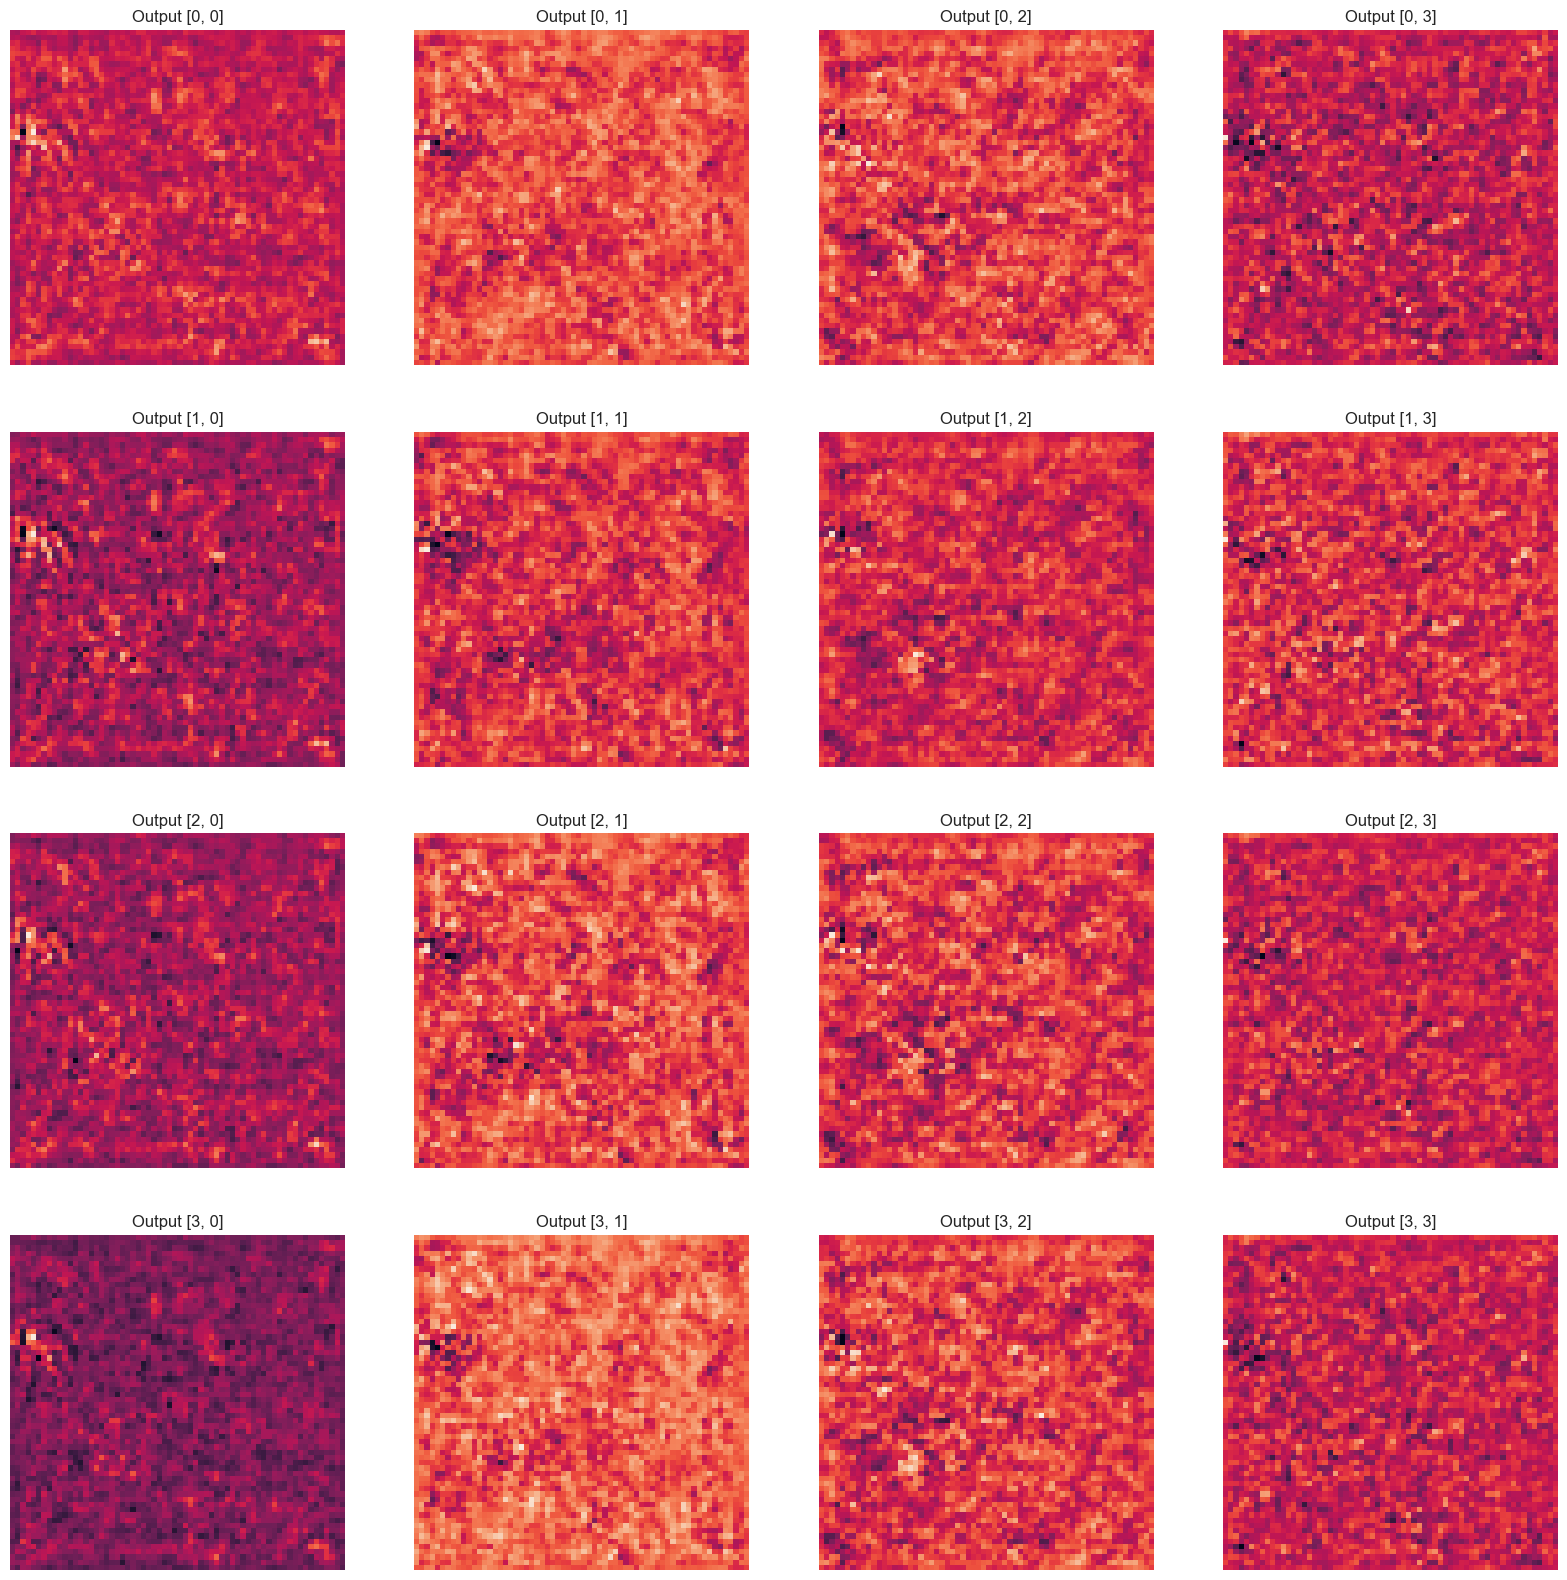

In [33]:
_, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(output[i, j].detach().numpy())
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Output {[i, j]}')

# plt.savefig("assets/unet_output.png")

---

In [34]:
class VAEDecoder(nn.Module):
    def __init__(
        self, 
        in_channels: int = 4,
        out_channels: int = 3,
        hidden_dims: list = [64, 128, 256, 512],
        activation_function: str = "silu",
        # cond_dim: int = 256,
        device: str = "cuda",
    ):
        super(VAEDecoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_dims = hidden_dims
        self.device = device

        # First layer: Projection (from 4 channels to the first hidden dimension)
        self.proj = nn.Sequential(
            nn.ConvTranspose2d(in_channels, hidden_dims[0], kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_dims[0]),
        ) 
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList()
        current_dim = hidden_dims[0]
        
        for i in range(1, len(hidden_dims)):
            decoder_block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(current_dim, hidden_dims[i] // 2, kernel_size=3, padding=1),
                nn.BatchNorm2d(hidden_dims[i] // 2),
                nn.SiLU() if activation_function == "silu" else nn.ReLU(),
                
                nn.Conv2d(hidden_dims[i] // 2, hidden_dims[i] // 2, kernel_size=3, padding=1),
                nn.BatchNorm2d(hidden_dims[i] // 2),
                nn.SiLU() if activation_function == "silu" else nn.ReLU()
            )
            self.decoder_layers.append(decoder_block)
            current_dim = hidden_dims[i] // 2

        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Conv2d(current_dim, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        print(f"Input shape: {x.shape}")

        # Initial projection
        x = self.proj(x)
        print(f"After projection: {x.shape}")
        
        # Decoder layers
        for i, layer in enumerate(self.decoder_layers):
            x = layer(x)
            print(f"After decoder layer {i}: {x.shape}")

        # Final output layer
        output = self.final_layer(x)
        print(f"Final output shape: {output.shape}")
        
        return output

In [35]:
# Testing with a shape of [1, 4, 64, 64]
decoder = VAEDecoder()
x = output
output = decoder(x)

Input shape: torch.Size([4, 4, 64, 64])
After projection: torch.Size([4, 64, 64, 64])
After decoder layer 0: torch.Size([4, 64, 128, 128])
After decoder layer 1: torch.Size([4, 128, 256, 256])
After decoder layer 2: torch.Size([4, 256, 512, 512])
Final output shape: torch.Size([4, 3, 512, 512])


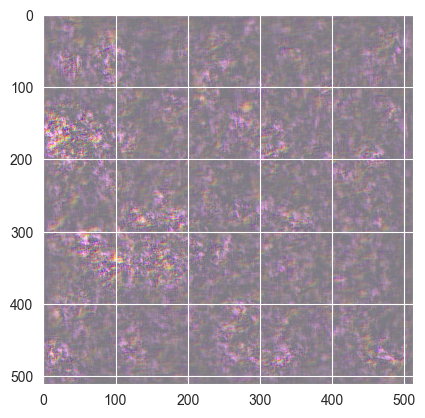

In [36]:
plt.imshow(output.permute(0, 2, 3, 1).detach().numpy()[0])

---

In [37]:
class StyleTransferPipeline(nn.Module):
    """
    Complete pipeline for style transfer on tumor staining images
    """
    def __init__(
        self,
        in_channels: int = 3,
        latent_channels: int = 4,
        out_channels: int = 3,
        cond_dim: int = 256,
        device: str = "cuda",
        unet_model_channels: int = 64,
        unet_num_res_blocks: int = 2,
        unet_channel_mult: Tuple[int, ...] = (1, 2, 4, 8),
        *args,
        **kwargs
    ):
        super(StyleTransferPipeline, self).__init__()
        self.device = device

        # VAE Encoder
        self.encoder = VAEncoder(
            in_channels=in_channels,
            latent_channels=latent_channels,
            cond_dim=cond_dim,
            device=device
        )

        # UNet Model
        model_params = {
            'out_channels': 4,
            'model_channels': 32,
            'num_res_blocks': 2,
            'dropout': 0.1,
            'in_channels': 4,
            'image_size': 32,
            'use_scale_shift_norm': True,
            'resblock_updown': False,  # Disable excessive downsampling
            'num_classes': None,
            'channel_mult': (1, 2, 4),  # Reduce max depth
            # 'device': torch.device('cpu'),
            # 'dtype': torch.float32
        }

        self.unet = UNetModel(**model_params)

        # VAE Decoder
        self.decoder = VAEDecoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            hidden_dims=[64, 128, 256, 512],
            device=device
        )

    def forward(
        self, 
        x: torch.Tensor, 
        style_condition: torch.Tensor, 
        timesteps: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass of the pipeline
        Args:
            x: Input image tensor of shape [batch_size, 3, H, W]
            style_condition: Style embedding tensor of shape [batch_size, 256]
            timesteps: Timestep tensor for UNet
        Returns:
            Styled output image of shape [batch_size, 3, H, W]
        """
        # Encode input to latent space
        latent = self.encoder(x)

        print("\nVAE Encoder Output Shape:", latent.shape,"\n")
        
        # Process with UNet
        unet_output = self.unet(latent, timesteps)
        print("\nUnet Output Shape:", unet_output.shape,"\n")
        
        # Decode back to image space
        output = self.decoder(unet_output)
        print("\nOutput Shape:", output.shape,"\n")
        
        return output

In [38]:
test = StyleTransferPipeline()

In [ ]:
test_output = test(tensor_patch_src, style_embedding, timesteps)

Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])

VAE Encoder Output Shape: torch.Size([1, 4, 32, 32]) 

After Conv2d: torch.Size([1, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After Downsample: torch.Size([4, 32, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After Downsample: torch.Size([4, 64, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 64, 16, 16]), skip=torch.Size([4, 64, 16, 16])
Upsampling: h=torch.Size([4, 64, 32, 32]), skip=torch.Size([4, 32, 32, 32])
Upsampling: h=tor

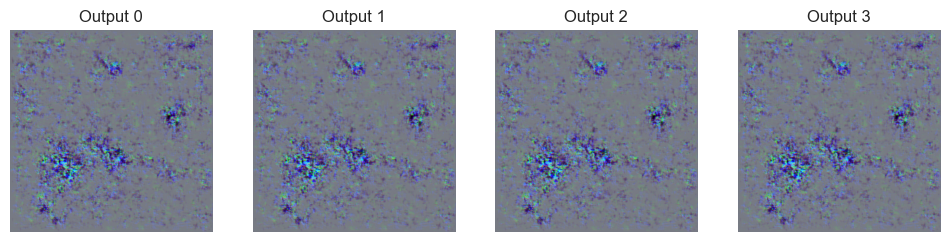

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
for j in range(len(test_output)):
    ax[j].imshow(test_output.permute(0, 2, 3, 1).detach().numpy()[i])
    ax[j].axis('off')
    ax[j].set_title(f'Output {j}')

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Create datasets and dataloaders for tumor images
class TumorImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

# Function to extract style embedding from style image using CLIP
def extract_style_embedding(style_image_path, device="cuda"):
    """Extract style embedding from a style reference image"""
    from .vit import extract_style_embedding as extract_emb
    style_emb = extract_emb(style_image_path, device=device)
    return style_emb

# Main training function
def train_tumor_style_transfer(
    content_dir,
    style_image_path,
    output_dir="./stylized_output",
    num_epochs=100,
    batch_size=8,
    lr=1e-4,
    device="cuda",
    save_interval=10
):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up data loading
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    dataset = TumorImageDataset(content_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Extract style embedding
    style_embedding = extract_style_embedding(style_image_path, device)
    
    # Initialize model
    model = TumorStyleTransferModel(
        latent_channels=4,
        model_channels=64,
        cond_dim=style_embedding.shape[1],
        device=device
    ).to(device)
    
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, content_images in enumerate(tqdm(dataloader)):
            content_images = content_images.to(device)
            batch_style_embedding = style_embedding.repeat(content_images.shape[0], 1)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            stylized_images = model(content_images, batch_style_embedding)
            
            # Calculate losses
            # 1. Structure preservation loss
            struct_loss = structure_preservation_loss(
                content_images, stylized_images, lambda_structure=1.0
            )
            
            # 2. Style loss could be added here
            
            # Total loss
            total_loss = struct_loss
            
            # Backward and optimize
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        # Print epoch stats
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        # Save model and sample outputs periodically
        if (epoch + 1) % save_interval == 0:
            # Save model
            torch.save(model.state_dict(), f"{output_dir}/model_epoch_{epoch+1}.pt")
            
            # Generate and save sample outputs
            model.eval()
            with torch.no_grad():
                # Take first batch from dataloader for visualization
                sample_content = next(iter(dataloader)).to(device)
                sample_style_emb = style_embedding.repeat(sample_content.shape[0], 1)
                sample_output = model(sample_content, sample_style_emb)
                
                # Save sample images
                for i in range(min(4, sample_content.shape[0])):
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    
                    # Convert tensors to numpy arrays for visualization
                    content_np = sample_content[i].cpu().permute(1, 2, 0).numpy()
                    output_np = sample_output[i].cpu().permute(1, 2, 0).numpy()
                    
                    # Clip values to valid range
                    content_np = np.clip(content_np, 0, 1)
                    output_np = np.clip(output_np, 0, 1)
                    
                    # Display images
                    axes[0].imshow(content_np)
                    axes[0].set_title("Original")
                    axes[0].axis('off')
                    
                    axes[1].imshow(output_np)
                    axes[1].set_title("Stylized")
                    axes[1].axis('off')
                    
                    plt.savefig(f"{output_dir}/sample_{epoch+1}_{i}.png")
                    plt.close()
    
    print("Training complete!")
    return model

In [ ]:
import torch.optim as optim

model = StyleTransferPipeline()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

tmp = []

for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    
    for i in range(10):
        content_images = convert_patch_to_tensor(normalize_patch(patches_src[i]))
        batch_style_embedding = style_embedding.repeat(content_images.shape[0], 1)
        print(f"Content images shape: {content_images.shape}")

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        stylized_images = model(content_images, batch_style_embedding, timesteps)
        
        # Calculate losses
        # 1. Structure preservation loss
        struct_loss = structure_preservation_loss(
            content_images, stylized_images, lambda_structure=1.0
        )
        
        # 2. Style loss could be added here
        
        # Total loss
        total_loss = struct_loss
        
        # Backward and optimize
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        tmp.append(epoch_loss)


Content images shape: torch.Size([1, 3, 128, 128])
Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])

VAE Encoder Output Shape: torch.Size([1, 4, 32, 32]) 

After Conv2d: torch.Size([1, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After Downsample: torch.Size([4, 32, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After Downsample: torch.Size([4, 64, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 64, 16, 16]), skip=torch.Size([4, 64, 16, 16])
Upsampling: h=torch.Size([4, 64, 32, 32]),

/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_14579/836960492.py:11: UserWarning: Using a target size (torch.Size([1, 3, 128, 128])) that is different to the input size (torch.Size([4, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(generated_image_resized, original_image)
/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_14579/836960492.py:30: UserWarning: Using a target size (torch.Size([1, 3, 128, 128])) that is different to the input size (torch.Size([4, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  edge_loss = F.mse_loss(gen_edges, orig_edges)


Content images shape: torch.Size([1, 3, 128, 128])
Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])

VAE Encoder Output Shape: torch.Size([1, 4, 32, 32]) 

After Conv2d: torch.Size([1, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After Downsample: torch.Size([4, 32, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After Downsample: torch.Size([4, 64, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])
Upsampling: h=torch.Size([4, 64, 16, 16]), skip=torch.Size([4, 64, 16, 16])
Upsampling: h=torch.Size([4, 64, 32, 32]),